# Sleep Estimation Function

This notebook analyzes YouTube history data to estimate sleep patterns based on activity gaps.
It converts timestamps to Eastern Standard Time (EST) and applies constraints to detect likely sleep periods.

The script then aggregates daily and weekly metrics (e.g., total videos, watch time via capped gaps, and inter-event durations)
and generates several graphs which are stored in a subdirectory called "graphs".

Use the detailed README to process your own data.

### Imports

In [63]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Data Loading and Parsing Functions

In [64]:
def load_history(file_path):
    """Load JSON data from a file."""
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

def parse_record(record):
    """
    Parse an individual record.
    Accept only entries whose "title" starts with "Watched" and that do not contain "From Google Ads".
    """
    if "details" in record:
        for detail in record["details"]:
            if detail.get("name", "").strip() == "From Google Ads":
                return None
    title = record.get("title", "")
    if not title.startswith("Watched"):
        return None
    time_str = record.get("time")
    try:
        dt = pd.to_datetime(time_str)  # parsed in UTC by default
    except Exception:
        return None
    return {"datetime": dt, "title": title}

def load_and_parse_histories(watch_file, search_file):
    """Load and combine valid records from the two JSON files."""
    watch_data = load_history(watch_file)
    search_data = load_history(search_file)
    records = []
    for rec in watch_data:
        parsed = parse_record(rec)
        if parsed:
            records.append(parsed)
    for rec in search_data:
        parsed = parse_record(rec)
        if parsed:
            records.append(parsed)
    return records

### Sleep Estimation Function

In [65]:
def estimate_sleep_periods(df, threshold_hours=5):
    """
    Estimate sleep periods based on gaps longer than threshold_hours.
    For each gap, convert the final event before the gap ("sleep_start") and the first event after ("sleep_end")
    from UTC to Eastern Standard Time (EST), then only accept the candidate if:
      - The gap duration is between 3 and 12 hours.
      - The sleep_start (final video before sleep) is roughly between 2 AM and 7 AM.
      - The sleep_end (first video after sleep) is roughly between 10 AM and 2 PM.
    """
    df_sorted = df.sort_values("datetime").reset_index(drop=True)
    df_sorted["time_diff"] = df_sorted["datetime"].diff()
    threshold = pd.Timedelta(hours=threshold_hours)
    sleep_periods = []
    for i in range(1, len(df_sorted)):
        if df_sorted.loc[i, "time_diff"] > threshold:
            # Convert times to EST
            sleep_start_est = df_sorted.loc[i-1, "datetime"].tz_convert("America/New_York")
            sleep_end_est = df_sorted.loc[i, "datetime"].tz_convert("America/New_York")
            duration = sleep_end_est - sleep_start_est
            if duration < pd.Timedelta(hours=3) or duration > pd.Timedelta(hours=12):
                continue
            final_video_hour = sleep_start_est.hour + sleep_start_est.minute / 60 + sleep_start_est.second / 3600
            first_video_hour = sleep_end_est.hour + sleep_end_est.minute / 60 + sleep_end_est.second / 3600
            if not (2 <= final_video_hour <= 7):
                continue
            if not (10 <= first_video_hour <= 14):
                continue
            sleep_periods.append({
                "sleep_start": sleep_start_est,
                "sleep_end": sleep_end_est,
                "duration": duration,
                "final_video_hour": final_video_hour,
                "first_video_hour": first_video_hour
            })
    return pd.DataFrame(sleep_periods)

### Day-Level Aggregation Functions

In [66]:
def compute_estimated_durations(events):
    """
    Compute the gap between consecutive events (capped at 15 minutes or 900 sec)
    for events in one day. Returns a list of durations in seconds.
    """
    cap_seconds = 900  # 15 minutes
    durations = []
    times = events["datetime"].tolist()
    for i in range(len(times) - 1):
        gap_sec = (times[i+1] - times[i]).total_seconds()
        durations.append(min(gap_sec, cap_seconds))
    return durations

def aggregate_day_metrics(df, sleep_df):
    """
    Define "days" using consecutive sleep_end times (which denote day-start boundaries).
    For each day interval, compute:
      - The total number of videos watched.
      - The estimated total watch time (sum of capped gaps in seconds).
      - The average inter-event duration.
      - The video length differential (difference between first and last gap).
      
    Updated: If there is activity after the last sleep boundary, we add an extra boundary using the time of the last event.
    """
    sleep_end_times = sorted(sleep_df["sleep_end"].tolist())
    last_event_time = df["datetime"].max()
    if last_event_time > sleep_end_times[-1]:
        sleep_end_times.append(last_event_time)
    
    day_records = []
    for i in range(1, len(sleep_end_times)):
        day_start = sleep_end_times[i-1]
        day_end = sleep_end_times[i]
        subset = df[(df["datetime"] >= day_start) & (df["datetime"] < day_end)].sort_values("datetime")
        if subset.empty:
            continue
        total_videos = len(subset)
        durations = compute_estimated_durations(subset)
        total_time = sum(durations) if durations else 0
        avg_duration = total_time / len(durations) if durations else 0
        length_diff = durations[0] - durations[-1] if durations else 0
        day_records.append({
            "day_start": day_start,
            "day_end": day_end,
            "total_videos": total_videos,
            "total_time": total_time,       # in seconds
            "avg_duration": avg_duration,   # in seconds
            "length_diff": length_diff
        })
    return pd.DataFrame(day_records)

def aggregate_weekly(day_df, overall_start):
    """
    Aggregate the day-level metrics into weeks based on the day_start relative to an overall start date.
    """
    day_df = day_df.copy()
    day_df["week_index"] = day_df["day_start"].apply(lambda x: (x - overall_start).days // 7)
    weekly = day_df.groupby("week_index").agg({
        "total_videos": "sum",
        "total_time": "sum",
        "avg_duration": "mean",
        "length_diff": "mean"
    }).reset_index()
    return weekly

def aggregate_sleep_by_week(sleep_df, overall_start):
    """
    Group sleep boundary metrics by week.
    """
    sleep_df = sleep_df.copy()
    sleep_df["week_index"] = sleep_df["sleep_start"].apply(lambda x: (x - overall_start).days // 7)
    weekly = sleep_df.groupby("week_index").agg({
        "final_video_hour": "mean",
        "first_video_hour": "mean"
    }).reset_index()
    return weekly

def aggregate_sleep_by_day(sleep_df, start_date, end_date):
    """
    Group sleep boundary records by day for a specified date range.
    """
    sleep_day = sleep_df[(sleep_df["sleep_start"] >= start_date) & (sleep_df["sleep_start"] <= end_date)].copy()
    sleep_day["day"] = sleep_day["sleep_start"].dt.date
    daily = sleep_day.groupby("day").agg({
        "final_video_hour": "mean",
        "first_video_hour": "mean"
    }).reset_index()
    return daily

### Main Analysis and Plotting

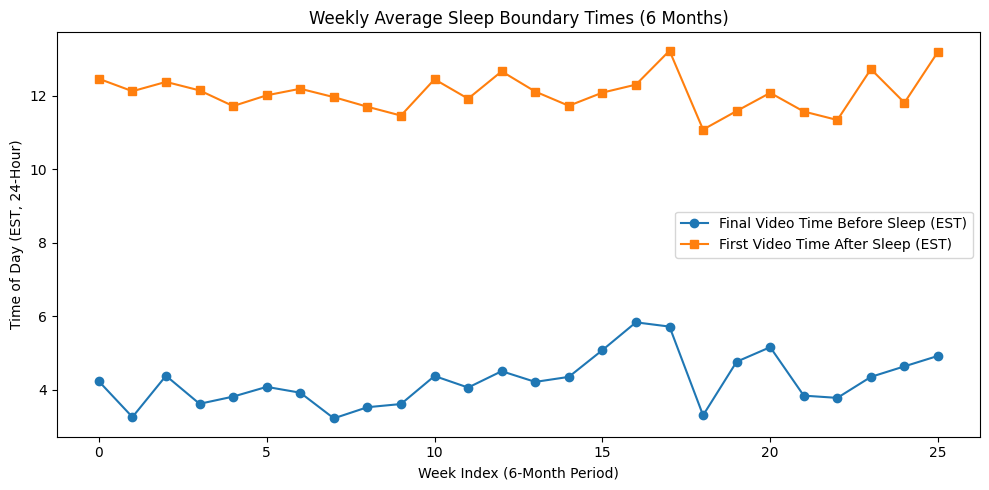

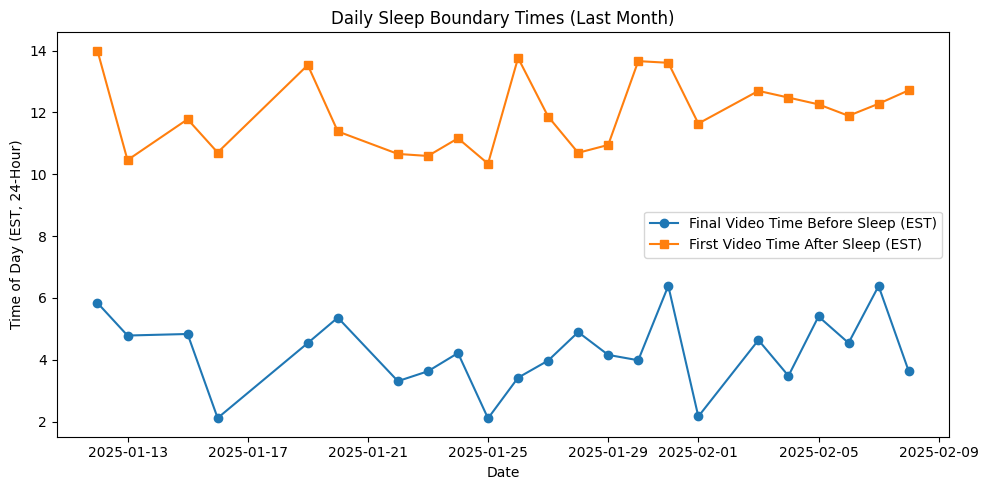

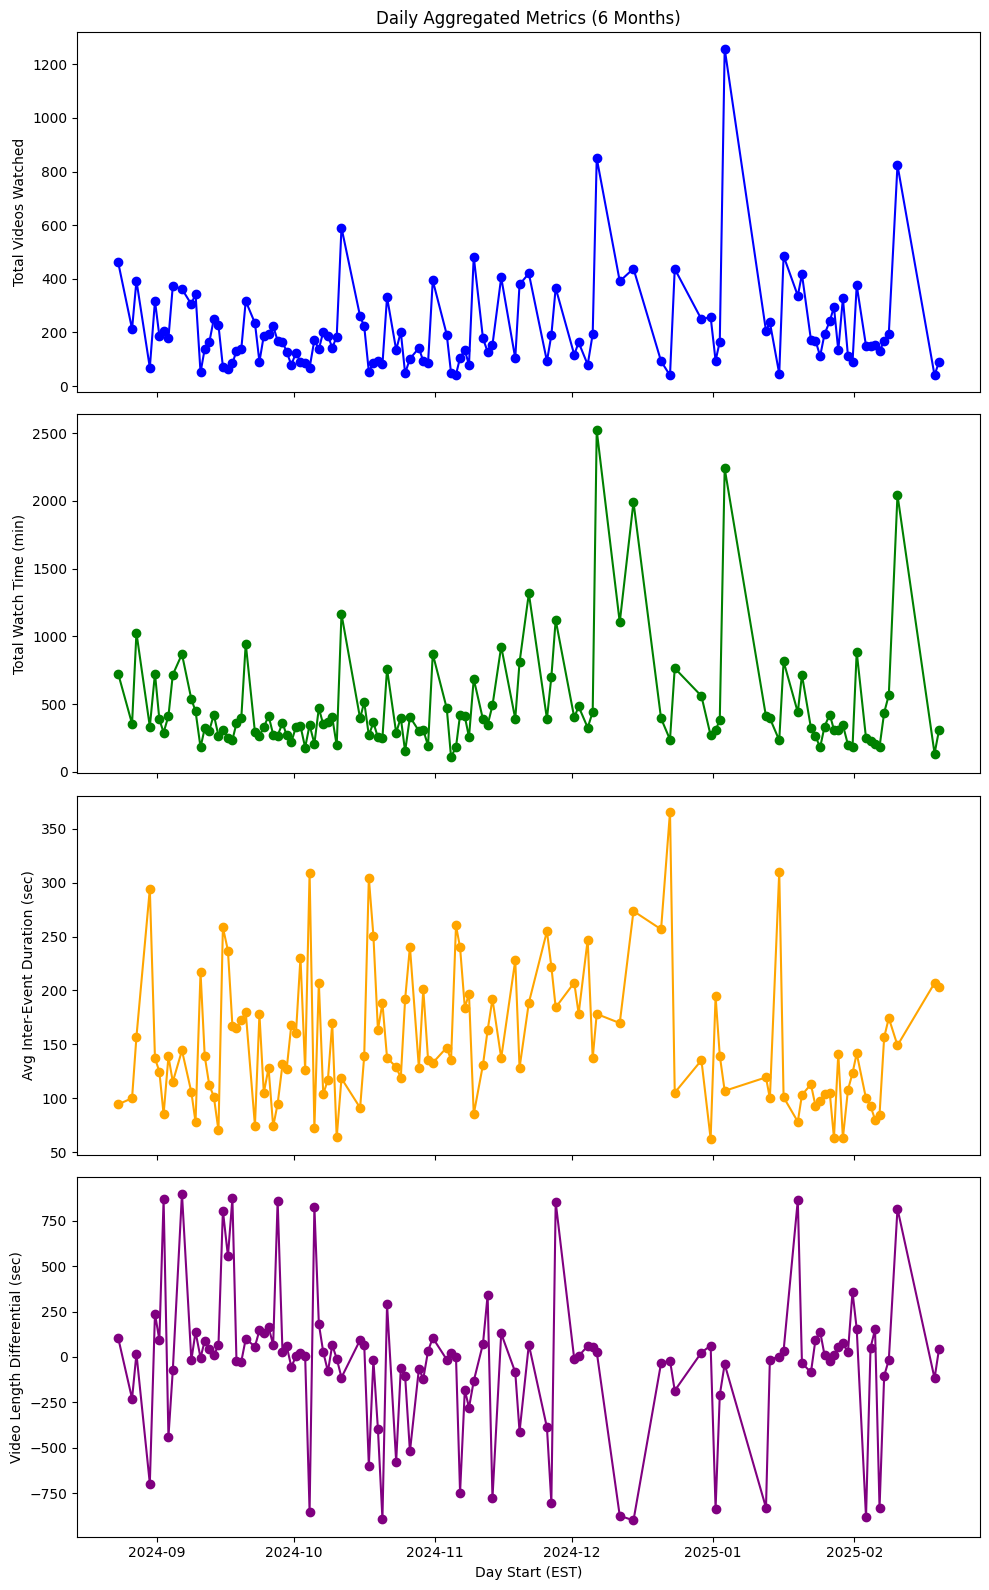

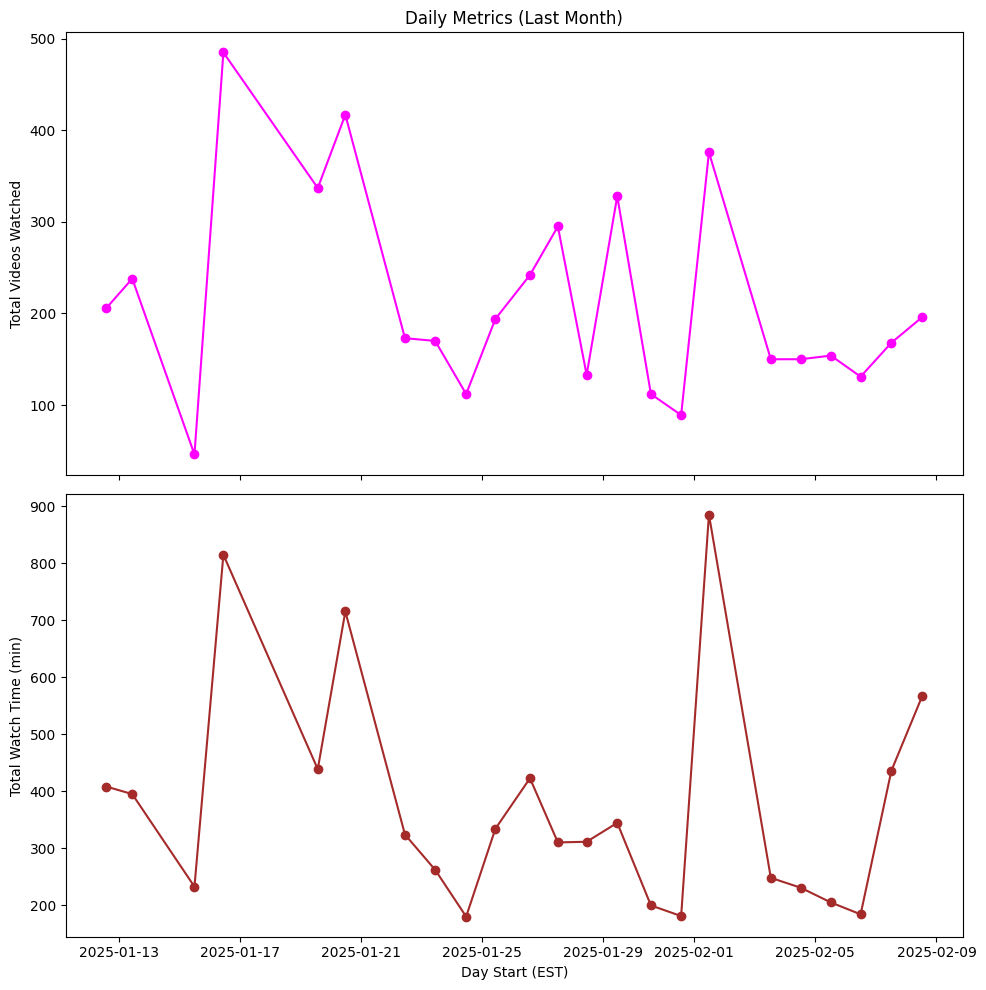

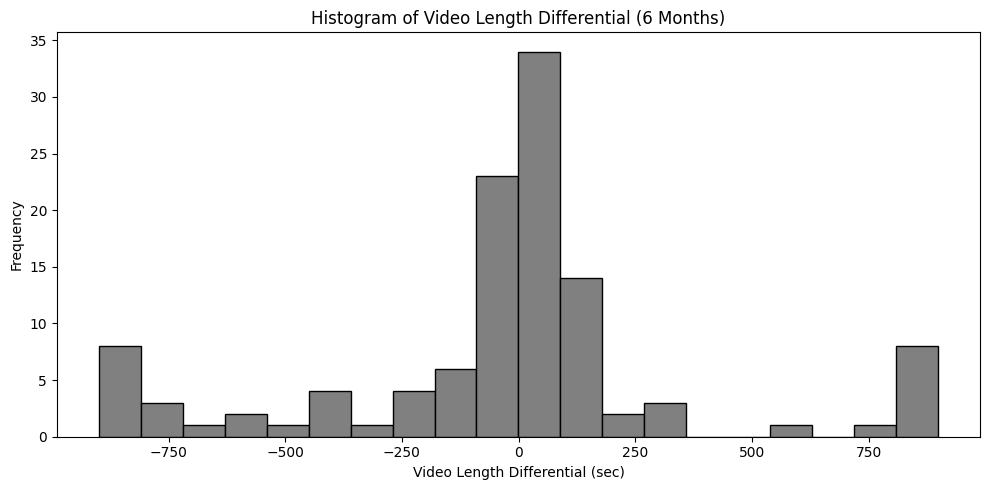

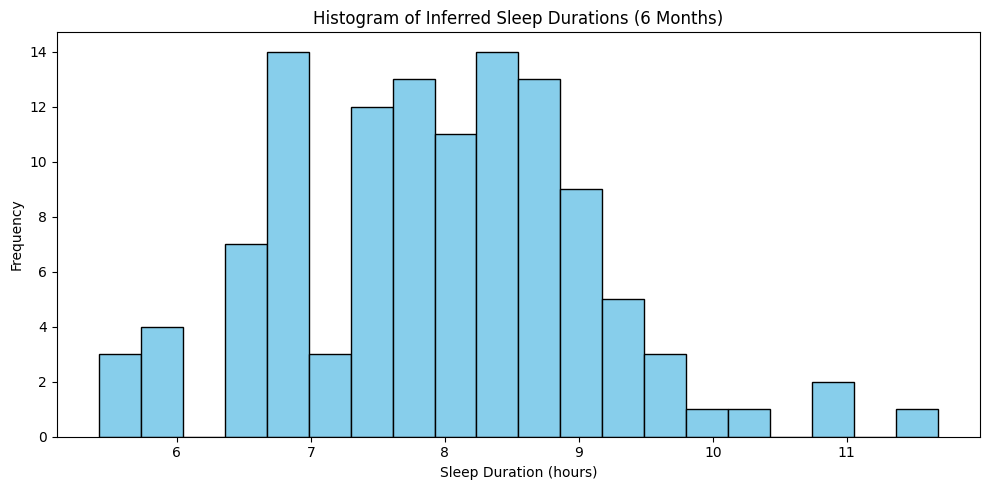

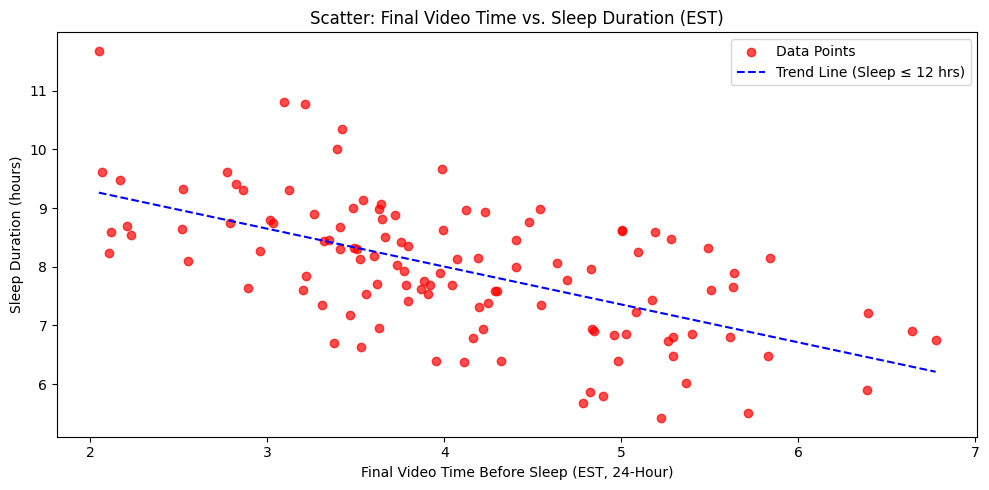

In [67]:
def main():
    # Create a subdirectory for graphs if it doesn't exist.
    graphs_dir = "graphs"
    os.makedirs(graphs_dir, exist_ok=True)
    
    # Define file paths (ensure the "history" directory is in the same directory as this script/notebook)
    watch_file = os.path.join("history", "watch-history.json")
    search_file = os.path.join("history", "search-history.json")
    
    records = load_and_parse_histories(watch_file, search_file)
    if not records:
        print("No valid records found.")
        return
    df = pd.DataFrame(records)
    
    # Filter to the target 6-month period: Aug 22, 2024 to Feb 22, 2025.
    start_range = pd.to_datetime("2024-08-22").tz_localize("UTC")
    end_range = pd.to_datetime("2025-02-22").tz_localize("UTC")
    df = df[(df["datetime"] >= start_range) & (df["datetime"] <= end_range)].reset_index(drop=True)
    df.sort_values("datetime", inplace=True)
    
    sleep_df = estimate_sleep_periods(df, threshold_hours=5)
    if sleep_df.empty:
        print("No sleep periods detected based on the current filters.")
        return

    day_df = aggregate_day_metrics(df, sleep_df)
    if day_df.empty:
        print("No day metrics computed.")
        return
    
    overall_start = start_range.tz_convert("America/New_York")
    weekly_day = aggregate_weekly(day_df, overall_start)
    weekly_sleep = aggregate_sleep_by_week(sleep_df, overall_start)
    
    # Update the last month range to be prior to 2025-02-09 (for example, 2025-01-09 to 2025-02-09)
    last_month_end = pd.to_datetime("2025-02-09").tz_localize("UTC")
    last_month_start = last_month_end - pd.Timedelta(days=30)
    last_month_end_est = last_month_end.tz_convert("America/New_York")
    last_month_start_est = last_month_start.tz_convert("America/New_York")
    
    daily_sleep_last_month = aggregate_sleep_by_day(sleep_df, last_month_start_est, last_month_end_est)
    last_month_day_df = day_df[(day_df["day_start"] >= last_month_start_est) & (day_df["day_start"] <= last_month_end_est)]
    
    ###############################
    # Generate Graphs with Improved Legends and Save to 'graphs' Subdirectory
    ###############################
    
    ## Graph 1: Weekly Average Sleep Boundary Times (6 Months)
    fig1, ax1 = plt.subplots(figsize=(10, 5))
    ax1.plot(weekly_sleep["week_index"], weekly_sleep["final_video_hour"],
             marker="o", label="Final Video Time Before Sleep (EST)")
    ax1.plot(weekly_sleep["week_index"], weekly_sleep["first_video_hour"],
             marker="s", label="First Video Time After Sleep (EST)")
    ax1.set_xlabel("Week Index (6-Month Period)")
    ax1.set_ylabel("Time of Day (EST, 24-Hour)")
    ax1.set_title("Weekly Average Sleep Boundary Times (6 Months)")
    ax1.legend()
    plt.tight_layout()
    fig1.savefig(os.path.join(graphs_dir, "weekly_sleep_times_6m.png"))
    plt.show()
    
    ## Graph 2: Daily Sleep Boundary Times (Last Month)
    fig2, ax2 = plt.subplots(figsize=(10, 5))
    ax2.plot(daily_sleep_last_month["day"], daily_sleep_last_month["final_video_hour"],
             marker="o", label="Final Video Time Before Sleep (EST)")
    ax2.plot(daily_sleep_last_month["day"], daily_sleep_last_month["first_video_hour"],
             marker="s", label="First Video Time After Sleep (EST)")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Time of Day (EST, 24-Hour)")
    ax2.set_title("Daily Sleep Boundary Times (Last Month)")
    ax2.legend()
    plt.tight_layout()
    fig2.savefig(os.path.join(graphs_dir, "daily_sleep_times_last_month.png"))
    plt.show()
    
    ## Graph 3: Daily Aggregated Metrics (6 Months)
    fig3, axs3 = plt.subplots(4, 1, figsize=(10, 16), sharex=True)
    axs3[0].plot(day_df["day_start"], day_df["total_videos"], marker="o", color="blue")
    axs3[0].set_ylabel("Total Videos Watched")
    axs3[0].set_title("Daily Aggregated Metrics (6 Months)")
    
    axs3[1].plot(day_df["day_start"], day_df["total_time"] / 60, marker="o", color="green")
    axs3[1].set_ylabel("Total Watch Time (min)")
    
    axs3[2].plot(day_df["day_start"], day_df["avg_duration"], marker="o", color="orange")
    axs3[2].set_ylabel("Avg Inter-Event Duration (sec)")
    
    axs3[3].plot(day_df["day_start"], day_df["length_diff"], marker="o", color="purple")
    axs3[3].set_ylabel("Video Length Differential (sec)")
    axs3[3].set_xlabel("Day Start (EST)")
    
    plt.tight_layout()
    fig3.savefig(os.path.join(graphs_dir, "daily_metrics_6m.png"))
    plt.show()
    
    ## Graph 4: Daily Metrics (Last Month)
    fig4, axs4 = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    axs4[0].plot(last_month_day_df["day_start"], last_month_day_df["total_videos"],
                 marker="o", color="magenta")
    axs4[0].set_ylabel("Total Videos Watched")
    axs4[0].set_title("Daily Metrics (Last Month)")
    
    axs4[1].plot(last_month_day_df["day_start"], last_month_day_df["total_time"] / 60,
                 marker="o", color="brown")
    axs4[1].set_ylabel("Total Watch Time (min)")
    axs4[1].set_xlabel("Day Start (EST)")
    
    plt.tight_layout()
    fig4.savefig(os.path.join(graphs_dir, "daily_metrics_last_month.png"))
    plt.show()
    
    ## Graph 5: Histogram of Video Length Differential (6 Months)
    fig5, ax5 = plt.subplots(figsize=(10, 5))
    ax5.hist(day_df["length_diff"], bins=20, color="gray", edgecolor="black")
    ax5.set_xlabel("Video Length Differential (sec)")
    ax5.set_ylabel("Frequency")
    ax5.set_title("Histogram of Video Length Differential (6 Months)")
    plt.tight_layout()
    fig5.savefig(os.path.join(graphs_dir, "video_length_diff_hist_6m.png"))
    plt.show()
    
    ## Graph 6: Histogram of Inferred Sleep Durations (6 Months)
    fig6, ax6 = plt.subplots(figsize=(10, 5))
    durations_hours = sleep_df["duration"].dt.total_seconds() / 3600
    ax6.hist(durations_hours, bins=20, color="skyblue", edgecolor="black")
    ax6.set_xlabel("Sleep Duration (hours)")
    ax6.set_ylabel("Frequency")
    ax6.set_title("Histogram of Inferred Sleep Durations (6 Months)")
    plt.tight_layout()
    fig6.savefig(os.path.join(graphs_dir, "sleep_duration_hist_6m.png"))
    plt.show()
    
    ## Graph 7: Scatter Plot of Final Video Time vs. Sleep Duration (EST) with Trend Line
    fig7, ax7 = plt.subplots(figsize=(10, 5))
    sleep_durations = sleep_df["duration"].dt.total_seconds() / 3600
    ax7.scatter(sleep_df["final_video_hour"], sleep_durations, color="red", alpha=0.7, label="Data Points")
    filtered = sleep_df[sleep_df["duration"].dt.total_seconds() / 3600 <= 12]
    if not filtered.empty:
        x_filtered = filtered["final_video_hour"]
        y_filtered = filtered["duration"].dt.total_seconds() / 3600
        coef = np.polyfit(x_filtered, y_filtered, deg=1)
        poly1d_fn = np.poly1d(coef)
        x_range = np.linspace(x_filtered.min(), x_filtered.max(), 100)
        ax7.plot(x_range, poly1d_fn(x_range), color="blue", linestyle="--",
                 label="Trend Line (Sleep ≤ 12 hrs)")
    ax7.set_xlabel("Final Video Time Before Sleep (EST, 24-Hour)")
    ax7.set_ylabel("Sleep Duration (hours)")
    ax7.set_title("Scatter: Final Video Time vs. Sleep Duration (EST)")
    ax7.legend()
    plt.tight_layout()
    fig7.savefig(os.path.join(graphs_dir, "final_time_vs_sleep_duration.png"))
    plt.show()

if __name__ == "__main__":
    main()